# Paths

In [ ]:
## local machine
src_path = '../src/'
lib_path = '../lib/'
input_path = '../../kaggle/input/home-credit-default-risk/'

In [2]:
# # Google Colab
# # Load the Drive helper and mount
# from google.colab import drive

# # This will prompt for authorization.
# drive.mount('/content/drive')

# # After executing above, Drive files will be accessible in path "/content/drive/MyDrive"

# # Google Colab
# src_path = '/content/drive/MyDrive/kaggle/src'
# lib_path = '/content/drive/MyDrive/kaggle/lib'
# input_path = '/content/drive/MyDrive/kaggle/input/home-credit-default-risk/'

In [3]:
# # Kaggle
# src_path = '/kaggle/src'
# lib_path = '/kaggle/lib/'
# input_path = '/kaggle/input/home-credit-default-risk/'

# Imports

In [4]:
import pandas as pd
pd.set_option("display.max_columns", 200)

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, TunedThresholdClassifierCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, make_scorer, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator

from sklearn import set_config
set_config(transform_output="pandas")

from xgboost import XGBClassifier, XGBRFClassifier

from lightgbm import LGBMClassifier

from category_encoders import HashingEncoder

import joblib
saved = joblib.load(lib_path + "data_processing.joblib")
preprocessor = saved["preprocessor"]
non_co_cols = saved["non_co_cols"]
merged_application_test = saved["merged_application_train"]

import sys
sys.path.insert(0, src_path)
from eval_classification import eval_classification
del sys.path[0]

In [5]:
# separate data
X = merged_application_test.drop(columns=["TARGET", "SK_ID_CURR"])
y = merged_application_test["TARGET"].copy()

In [6]:
# split data 80/20 for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [7]:
# fit data on preprocessor
preprocessor.fit(X_train, y_train)

# transform data
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [8]:
# drop columns with collinear relationships (Pearson's correlation coefficients > 0.8)
X_train.drop(columns=non_co_cols, inplace=True)
X_test.drop(columns=non_co_cols, inplace=True)

# Model Testing

## Logistic Regression

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.69      0.80    226132             0       0.96      0.69      0.80     56554 
           1       0.16      0.68      0.26     19876             1       0.16      0.67      0.26      4949 
                                                                                                             
    accuracy                           0.69    246008      accuracy                           0.69     61503 
   macro avg       0.56      0.68      0.53    246008     macro avg       0.56      0.68      0.53     61503 
weighted avg       0.90      0.69      0.76    246008  weighted avg       0.90      0.69      0.76     61503 


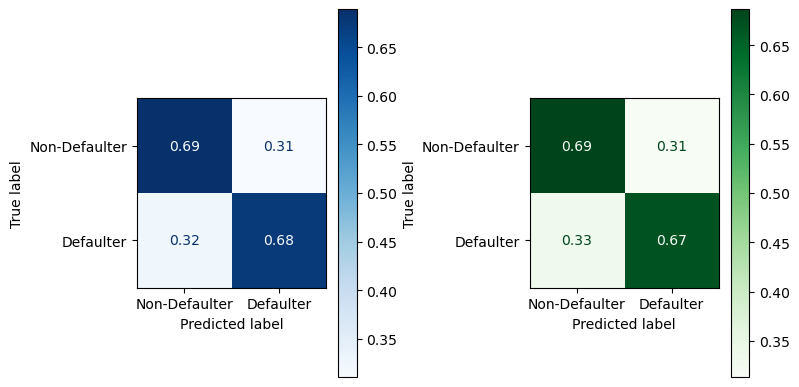

In [9]:
logreg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42).fit(X_train, y_train)

logreg_results = eval_classification(logreg, X_train, y_train, X_test, y_test,
                              model_name="Logistic Regression")

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.69      0.80    226132             0       0.96      0.69      0.80     56554 
           1       0.16      0.67      0.26     19876             1       0.16      0.67      0.26      4949 
                                                                                                             
    accuracy                           0.69    246008      accuracy                           0.69     61503 
   macro avg       0.56      0.68      0.53    246008     macro avg       0.56      0.68      0.53     61503 
weighted avg       0.90      0.69      0.76    246008  weighted avg       0.90      0.69      0.76     61503 


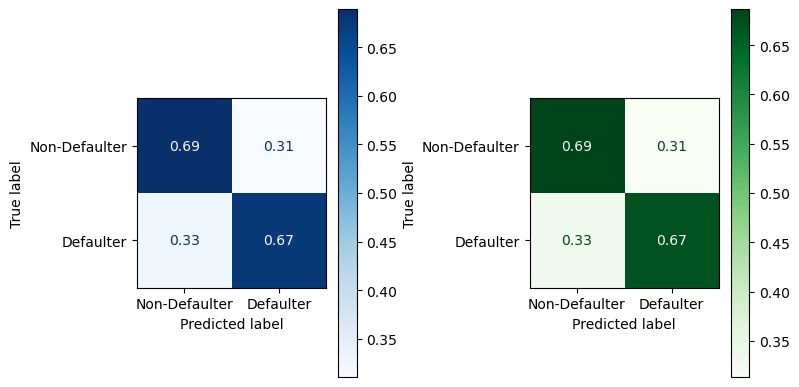

In [10]:
logreg_cv = LogisticRegressionCV(max_iter=1000, class_weight="balanced", scoring="roc_auc", n_jobs=-1, random_state=42).fit(X_train, y_train)

logreg_cv_results = eval_classification(logreg_cv, X_train, y_train, X_test, y_test,
                              model_name="Logistic Regression CV", results_frame=logreg_results)

In [11]:
logreg_cv_results

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.688201,0.685284,0.160394,0.157677,0.675186,0.670438,0.259211,0.255309,0.745930,0.743762
Logistic Regression CV,0.688100,0.685316,0.160257,0.157692,0.674633,0.670438,0.258991,0.255329,0.745894,0.743784


In [12]:
logreg_cv.get_params()

{'Cs': 10,
 'class_weight': 'balanced',
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 1000,
 'multi_class': 'deprecated',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'refit': True,
 'scoring': 'roc_auc',
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

## Decision Trees

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       1.00      1.00      1.00    226132             0       0.93      0.92      0.92     56554 
           1       1.00      1.00      1.00     19876             1       0.16      0.17      0.16      4949 
                                                                                                             
    accuracy                           1.00    246008      accuracy                           0.86     61503 
   macro avg       1.00      1.00      1.00    246008     macro avg       0.54      0.54      0.54     61503 
weighted avg       1.00      1.00      1.00    246008  weighted avg       0.86      0.86      0.86     61503 


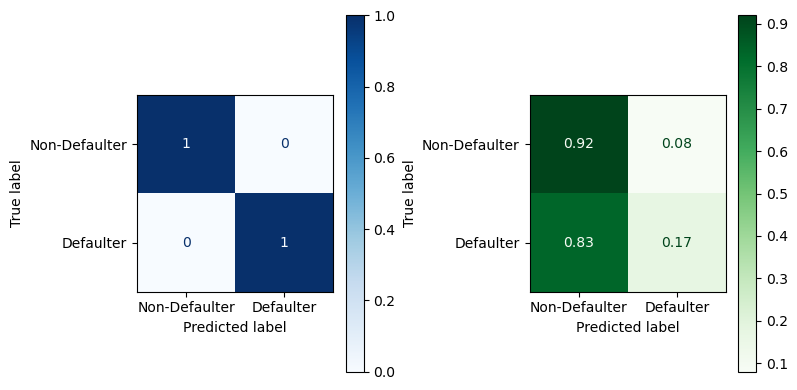

In [13]:
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced").fit(X_train, y_train)

dt_results = eval_classification(dt, X_train, y_train, X_test, y_test,
                                  model_name="Decision Tree", results_frame=logreg_cv_results)

In [14]:
dt.get_depth()

80

In [15]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.69      0.80    226132             0       0.96      0.68      0.80     56554 
           1       0.16      0.67      0.26     19876             1       0.15      0.64      0.24      4949 
                                                                                                             
    accuracy                           0.69    246008      accuracy                           0.68     61503 
   macro avg       0.56      0.68      0.53    246008     macro avg       0.55      0.66      0.52     61503 
weighted avg       0.90      0.69      0.76    246008  weighted avg       0.89      0.68      0.75     61503 


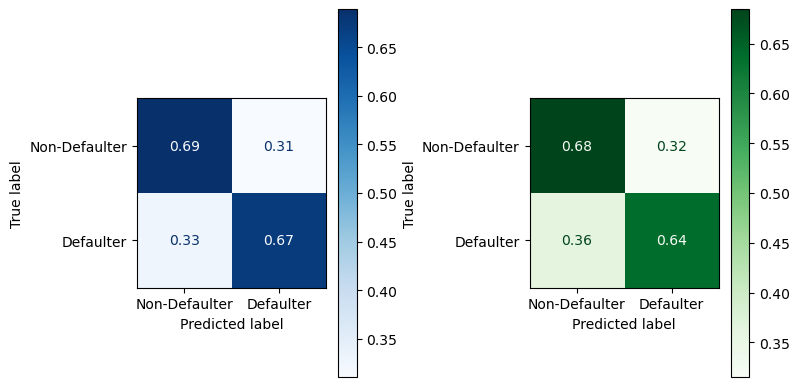

In [16]:
dt_params = {'max_depth' : [2, 4, 5, 8, 10, 16, 20, 40, 80]}
dt_gs = GridSearchCV(dt, dt_params, scoring="roc_auc", n_jobs=-1)
dt_gs.fit(X_train, y_train)
dt_cv = dt_gs.best_estimator_.fit(X_train, y_train)

dt_cv_results = eval_classification(dt_cv, X_train, y_train, X_test, y_test,
                                  model_name="Decision Tree CV", results_frame=dt_results)

In [17]:
dt_cv.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [18]:
dt_cv_results

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.688201,0.685284,0.160394,0.157677,0.675186,0.670438,0.259211,0.255309,0.745930,0.743762
Logistic Regression CV,0.688100,0.685316,0.160257,0.157692,0.674633,0.670438,0.258991,0.255329,0.745894,0.743784
Decision Tree,1.000000,0.859487,1.000000,0.156465,1.000000,0.169933,1.000000,0.162921,1.000000,0.544881
Decision Tree CV,0.688075,0.680910,0.159953,0.150405,0.672821,0.637907,0.258460,0.243417,0.744455,0.712928


                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.71      0.82    226132             0       0.96      0.71      0.81     56554 
           1       0.17      0.68      0.28     19876             1       0.16      0.62      0.25      4949 
                                                                                                             
    accuracy                           0.71    246008      accuracy                           0.70     61503 
   macro avg       0.57      0.70      0.55    246008     macro avg       0.56      0.67      0.53     61503 
weighted avg       0.90      0.71      0.78    246008  weighted avg       0.89      0.70      0.77     61503 


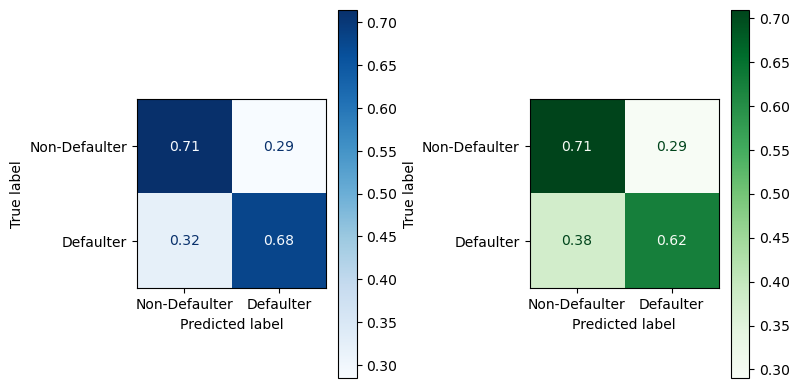

In [19]:
bdt = AdaBoostClassifier(dt_cv, random_state=42).fit(X_train, y_train)

bdt_results = eval_classification(bdt, X_train, y_train, X_test, y_test,
                                  model_name="AdaBoosted Decision Tree", results_frame=dt_cv_results)

In [20]:
bdt_results

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.688201,0.685284,0.160394,0.157677,0.675186,0.670438,0.259211,0.255309,0.745930,0.743762
Logistic Regression CV,0.688100,0.685316,0.160257,0.157692,0.674633,0.670438,0.258991,0.255329,0.745894,0.743784
Decision Tree,1.000000,0.859487,1.000000,0.156465,1.000000,0.169933,1.000000,0.162921,1.000000,0.544881
Decision Tree CV,0.688075,0.680910,0.159953,0.150405,0.672821,0.637907,0.258460,0.243417,0.744455,0.712928
AdaBoosted Decision Tree,0.711578,0.702307,0.172694,0.158032,0.677953,0.623762,0.275270,0.252175,0.758932,0.721342


## Random Forests

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       1.00      1.00      1.00    226132             0       0.92      1.00      0.96     56554 
           1       1.00      1.00      1.00     19876             1       0.50      0.00      0.00      4949 
                                                                                                             
    accuracy                           1.00    246008      accuracy                           0.92     61503 
   macro avg       1.00      1.00      1.00    246008     macro avg       0.71      0.50      0.48     61503 
weighted avg       1.00      1.00      1.00    246008  weighted avg       0.89      0.92      0.88     61503 


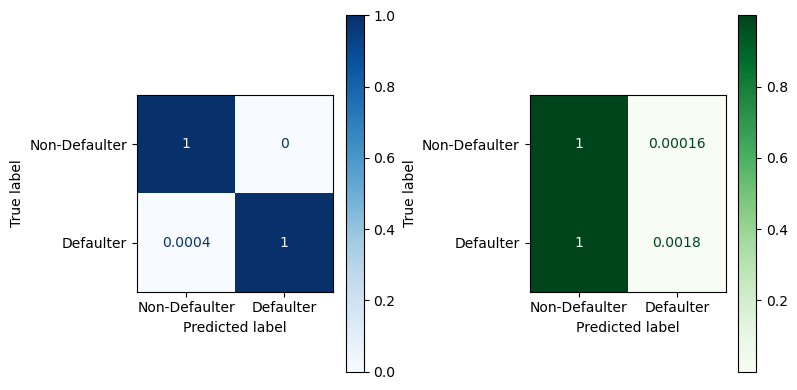

In [21]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced_subsample").fit(X_train, y_train)

rf_results = eval_classification(rf, X_train, y_train, X_test, y_test,
                                  model_name="Random Forest", results_frame=bdt_results)

In [22]:
estimators = rf.estimators_
depths = [est.get_depth() for est in estimators]
max(depths)

83

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.72      0.83    226132             0       0.96      0.72      0.82     56554 
           1       0.18      0.68      0.28     19876             1       0.17      0.64      0.26      4949 
                                                                                                             
    accuracy                           0.72    246008      accuracy                           0.71     61503 
   macro avg       0.57      0.70      0.55    246008     macro avg       0.56      0.68      0.54     61503 
weighted avg       0.90      0.72      0.78    246008  weighted avg       0.89      0.71      0.78     61503 


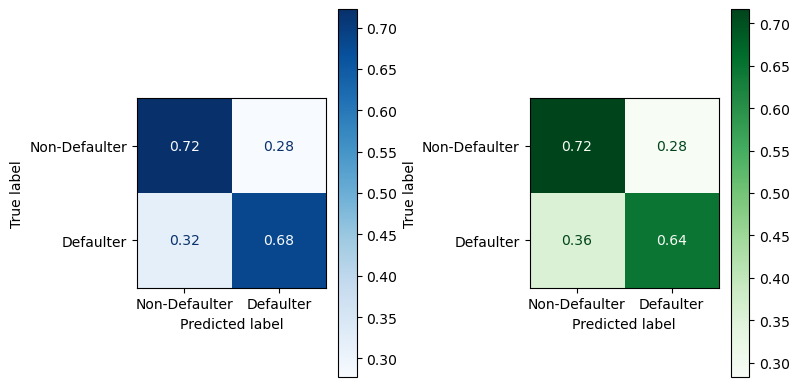

In [23]:
rf_params = {"n_estimators" : [20, 40, 60, 80],
             "max_depth" : [3, 8, 83]}
rf_gs = GridSearchCV(rf, rf_params, scoring="roc_auc", n_jobs=-1)
rf_gs.fit(X_train, y_train)
rf_cv = rf_gs.best_estimator_.fit(X_train, y_train)

rf_cv_results = eval_classification(rf_cv, X_train, y_train, X_test, y_test,
                                  model_name="Random Forest CV", results_frame=rf_results)

In [24]:
rf_cv.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 80,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## Gradient Boosting Models

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.97      0.72      0.83    226132             0       0.96      0.71      0.82     56554 
           1       0.19      0.74      0.30     19876             1       0.17      0.69      0.28      4949 
                                                                                                             
    accuracy                           0.72    246008      accuracy                           0.71     61503 
   macro avg       0.58      0.73      0.56    246008     macro avg       0.57      0.70      0.55     61503 
weighted avg       0.91      0.72      0.79    246008  weighted avg       0.90      0.71      0.78     61503 


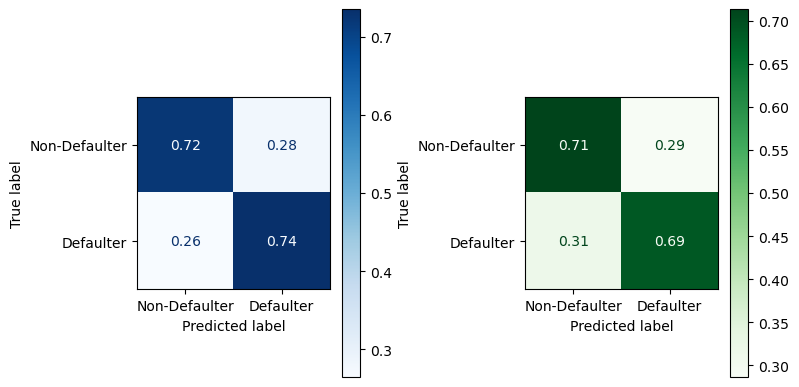

In [68]:
hgb = HistGradientBoostingClassifier(scoring="roc_auc", random_state=42, class_weight="balanced").fit(X_train, y_train)

hgb_results = eval_classification(hgb, X_train, y_train, X_test, y_test,
                                  model_name="Histogram-based Gradient Boosting Tree", results_frame=rf_cv_results)

In [70]:
hgb_results


,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.688201,0.685284,0.160394,0.157677,0.675186,0.670438,0.259211,0.255309,0.745930,0.743762
Logistic Regression CV,0.688100,0.685316,0.160257,0.157692,0.674633,0.670438,0.258991,0.255329,0.745894,0.743784
Decision Tree,1.000000,0.859487,1.000000,0.156465,1.000000,0.169933,1.000000,0.162921,1.000000,0.544881
Decision Tree CV,0.688075,0.680910,0.159953,0.150405,0.672821,0.637907,0.258460,0.243417,0.744455,0.712928
AdaBoosted Decision Tree,0.711578,0.702307,0.172694,0.158032,0.677953,0.623762,0.275270,0.252175,0.758932,0.721342
Random Forest,0.999967,0.919532,1.000000,0.500000,0.999598,0.001819,0.999799,0.003624,1.000000,0.736460
Random Forest CV,0.719192,0.711185,0.177501,0.166128,0.681274,0.644171,0.281626,0.264137,0.770360,0.743152
Histogram-based Gradient Boosting Tree,0.723598,0.711071,0.189000,0.172984,0.735661,0.685189,0.300737,0.276230,0.805845,0.769701


In [71]:
hgb.get_params()

{'categorical_features': 'from_dtype',
 'class_weight': 'balanced',
 'early_stopping': 'auto',
 'interaction_cst': None,
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_bins': 255,
 'max_depth': None,
 'max_features': 1.0,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': 42,
 'scoring': 'roc_auc',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [72]:
hgb.do_early_stopping_

True

In [73]:
hgb.n_iter_

100

In [74]:
hgb.n_trees_per_iteration_

1

In [75]:
hgb.train_score_

array([0.5       , 0.71083154, 0.7166224 , 0.72094728, 0.72489517,
       0.7280245 , 0.72897016, 0.73150539, 0.73237376, 0.73398016,
       0.73669958, 0.73909156, 0.74043009, 0.74187594, 0.7432616 ,
       0.74487339, 0.74598425, 0.74790094, 0.74929556, 0.7511118 ,
       0.75332066, 0.75414278, 0.75554144, 0.75650998, 0.75784279,
       0.75864997, 0.75953995, 0.76050634, 0.76185477, 0.76303706,
       0.76400499, 0.76518055, 0.76558057, 0.76680082, 0.76769161,
       0.76860852, 0.76946363, 0.77031106, 0.77111069, 0.7716191 ,
       0.7719864 , 0.77220614, 0.77294465, 0.77325809, 0.77357167,
       0.77420179, 0.77472595, 0.77520272, 0.7758319 , 0.77658387,
       0.77704636, 0.77764942, 0.77807933, 0.77849847, 0.7789996 ,
       0.77981742, 0.7800968 , 0.78069447, 0.78135515, 0.78165635,
       0.78202715, 0.78233198, 0.78291336, 0.78355398, 0.78414587,
       0.78475243, 0.7852607 , 0.78563083, 0.78615027, 0.78673273,
       0.78690373, 0.78722121, 0.78787947, 0.78833173, 0.78866

In [76]:
hgb.validation_score_

array([0.5       , 0.71119584, 0.72053104, 0.72486972, 0.72710032,
       0.72861987, 0.73063485, 0.73165666, 0.73292168, 0.73441097,
       0.73536844, 0.73651412, 0.73852646, 0.74005129, 0.74135516,
       0.74247374, 0.74374366, 0.74509417, 0.7465243 , 0.74780388,
       0.7491252 , 0.74933701, 0.75075792, 0.75160913, 0.75237991,
       0.75311565, 0.75363149, 0.75455665, 0.75544666, 0.75608494,
       0.75684523, 0.75763452, 0.75799366, 0.75887196, 0.75923497,
       0.75983578, 0.76032645, 0.76088077, 0.76142932, 0.76171002,
       0.76197947, 0.76209693, 0.76244081, 0.76248078, 0.76260246,
       0.7631933 , 0.76357686, 0.76379559, 0.76401677, 0.76419698,
       0.7645298 , 0.76468384, 0.76490776, 0.7651157 , 0.76503357,
       0.76545131, 0.7653753 , 0.76555508, 0.7658229 , 0.76603116,
       0.76629445, 0.76666633, 0.7668801 , 0.76699415, 0.76719853,
       0.76738944, 0.76795548, 0.76824641, 0.76846021, 0.76858451,
       0.76856947, 0.76860996, 0.76903817, 0.76918687, 0.76919

In [79]:
hgb_gs1_params = {'interaction_cst': [None, 'pairwise', 'no_interactions'],
                  'loss': ['log_loss', 'exponential'],
                  'validation_fraction': [0.1, 0.2]}
              
hgb_gs1 = GridSearchCV(hgb, hgb_gs1_params, scoring="roc_auc", n_jobs=-1)
hgb_gs1.fit(X_train, y_train)
hgb_1 = hgb_gs1.best_estimator_.fit(X_train, y_train)

/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fil

In [ ]:
hgb_gs2_params = {'max_bins': [127, 255, 511],
                  'max_iter': [10, 100, 1000]}
              
hgb_gs2 = GridSearchCV(hgb_1, hgb_gs2_params, scoring="roc_auc", n_jobs=-1)
hgb_gs2.fit(X_train, y_train)
hgb_2 = hgb_gs2.best_estimator_.fit(X_train, y_train)

In [ ]:
hgb_gs3_params = {'max_features': [1, 10, 100],
                  'max_leaf_nodes': [15, 31, 63]}
              
hgb_gs3 = GridSearchCV(hgb_2, hgb_gs3_params, scoring="roc_auc", n_jobs=-1)
hgb_gs3.fit(X_train, y_train)
hgb_3 = hgb_gs3.best_estimator_.fit(X_train, y_train)

hgb_tuned_results = eval_classification(hgb_3, X_train, y_train, X_test, y_test,
                                  model_name="Tuned HGBoost", results_frame=hgb_results)

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.93      1.00      0.96    226132             0       0.92      0.99      0.96     56554 
           1       0.81      0.11      0.19     19876             1       0.45      0.05      0.09      4949 
                                                                                                             
    accuracy                           0.93    246008      accuracy                           0.92     61503 
   macro avg       0.87      0.55      0.58    246008     macro avg       0.69      0.52      0.52     61503 
weighted avg       0.92      0.93      0.90    246008  weighted avg       0.88      0.92      0.89     61503 


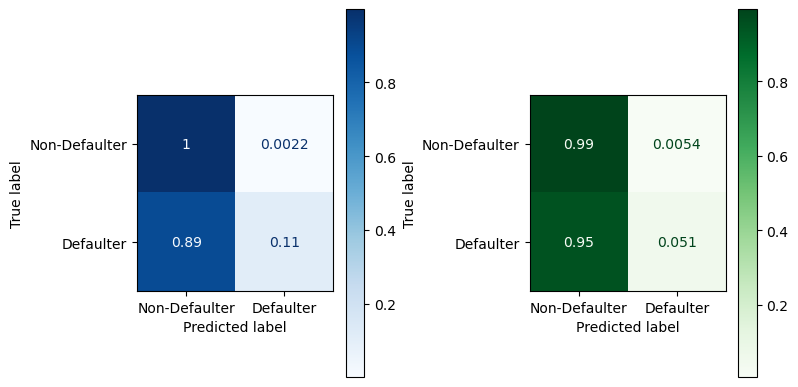

In [ ]:
xgb = XGBClassifier(eval_metric="auc", objective="binary:logistic", random_state=42).fit(X_train, y_train)

xgb_results = eval_classification(xgb, X_train, y_train, X_test, y_test,
                                  model_name="XGBoost", results_frame=hgb_tuned_results)

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.97      0.99      0.98    226132             0       0.93      0.97      0.95     56554 
           1       0.87      0.66      0.75     19876             1       0.35      0.17      0.22      4949 
                                                                                                             
    accuracy                           0.96    246008      accuracy                           0.91     61503 
   macro avg       0.92      0.83      0.87    246008     macro avg       0.64      0.57      0.59     61503 
weighted avg       0.96      0.96      0.96    246008  weighted avg       0.88      0.91      0.89     61503 


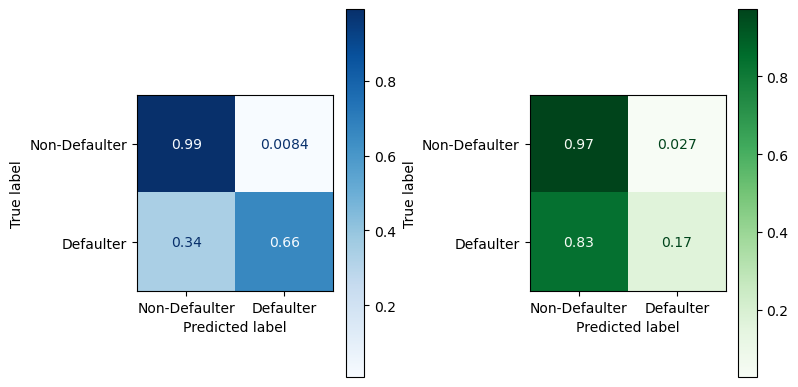

In [27]:
xgbrf = XGBRFClassifier(eval_metric="auc", objective="binary:logistic", seed=42, n_estimators=200, max_depth=83).fit(X_train, y_train)

xgbrf_results = eval_classification(xgbrf, X_train, y_train, X_test, y_test,
                                  model_name="XGBoost Random Forest", results_frame=xgb_results)

## Naive Bayes algorithms

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.03      0.06    226132             0       0.96      0.03      0.06     56554 
           1       0.08      0.98      0.15     19876             1       0.08      0.98      0.15      4949 
                                                                                                             
    accuracy                           0.11    246008      accuracy                           0.11     61503 
   macro avg       0.52      0.51      0.11    246008     macro avg       0.52      0.51      0.11     61503 
weighted avg       0.89      0.11      0.07    246008  weighted avg       0.89      0.11      0.07     61503 


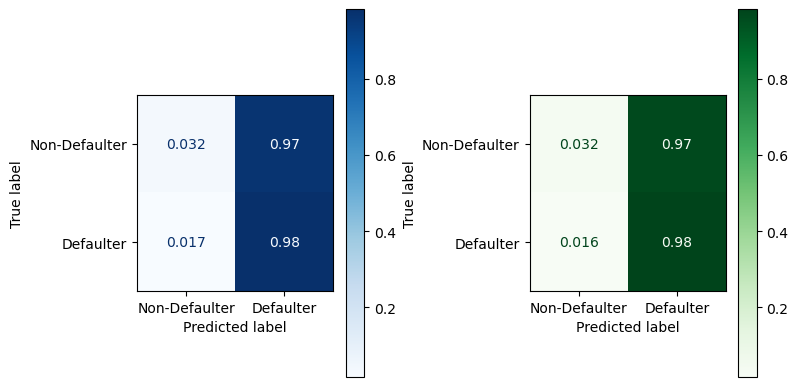

In [28]:
gnb = GaussianNB().fit(X_train, y_train)

gnb_results = eval_classification(gnb, X_train, y_train, X_test, y_test,
                                  model_name="Gaussian", results_frame=xgbrf_results)

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.93      0.92      0.93    226132             0       0.93      0.92      0.93     56554 
           1       0.19      0.21      0.20     19876             1       0.19      0.21      0.20      4949 
                                                                                                             
    accuracy                           0.87    246008      accuracy                           0.87     61503 
   macro avg       0.56      0.57      0.56    246008     macro avg       0.56      0.57      0.56     61503 
weighted avg       0.87      0.87      0.87    246008  weighted avg       0.87      0.87      0.87     61503 


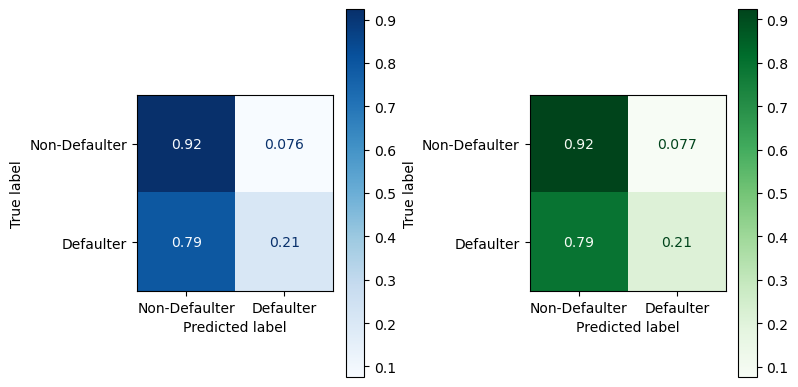

In [29]:
bnb = BernoulliNB().fit(X_train, y_train)

bnb_results = eval_classification(bnb, X_train, y_train, X_test, y_test,
                                  model_name="Bernoulli", results_frame=gnb_results)

# Export and Submission

## First we need to pick which model to use

In [ ]:
bnb_results.style.background_gradient(vmin=0, vmax=1)

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.688201,0.685284,0.160394,0.157677,0.675186,0.670438,0.259211,0.255309,0.745930,0.743762
Logistic Regression CV,0.688100,0.685316,0.160257,0.157692,0.674633,0.670438,0.258991,0.255329,0.745894,0.743784
Decision Tree,1.000000,0.859487,1.000000,0.156465,1.000000,0.169933,1.000000,0.162921,1.000000,0.544881
Decision Tree CV,0.688075,0.680910,0.159953,0.150405,0.672821,0.637907,0.258460,0.243417,0.744455,0.712928
AdaBoosted Decision Tree,0.711578,0.702307,0.172694,0.158032,0.677953,0.623762,0.275270,0.252175,0.758932,0.721342
Random Forest,0.999967,0.919532,1.000000,0.500000,0.999598,0.001819,0.999799,0.003624,1.000000,0.736460
Random Forest CV,0.719192,0.711185,0.177501,0.166128,0.681274,0.644171,0.281626,0.264137,0.770360,0.743152
Histogram-based Gradient Boosting Tree,0.728249,0.715380,0.192635,0.174917,0.740642,0.682562,0.305748,0.278472,0.812410,0.769900
XGBoost,0.925974,0.918638,0.812617,0.450980,0.108875,0.051121,0.192023,0.091833,0.866603,0.760074
XGBoost Random Forest,0.964757,0.907647,0.873086,0.345455,0.659690,0.165084,0.751533,0.223407,0.988605,0.745909


The highest test ROC AUC score, 2nd highest recall score, and 6th highest accuracy are from the Histogram-based Gradient Boosting Tree

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.97      0.73      0.83    226132             0       0.96      0.72      0.82     56554 
           1       0.19      0.74      0.31     19876             1       0.17      0.68      0.28      4949 
                                                                                                             
    accuracy                           0.73    246008      accuracy                           0.72     61503 
   macro avg       0.58      0.73      0.57    246008     macro avg       0.57      0.70      0.55     61503 
weighted avg       0.91      0.73      0.79    246008  weighted avg       0.90      0.72      0.78     61503 


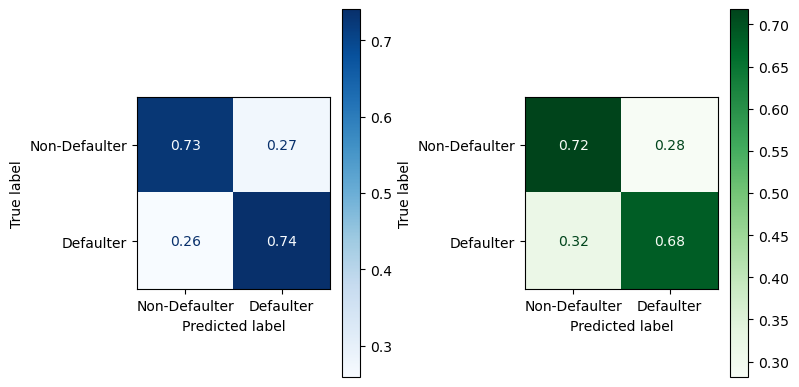

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Histogram-based Gradient Boosting Tree,0.728249,0.715380,0.192635,0.174917,0.740642,0.682562,0.305748,0.278472,0.812410,0.769900


In [61]:
eval_classification(hgb, X_train, y_train, X_test, y_test,
                                  model_name="Histogram-based Gradient Boosting Tree").style.background_gradient(vmin=0, vmax=1)

## Import test data and preliminary merge

In [35]:
test_data_file = "application_test.csv"
application_test = pd.read_csv(input_path + test_data_file)

bureau_loans_and_balances = pd.read_csv(lib_path + "bureau_loans_and_balances.csv")

installments_payments = pd.read_csv(input_path + "installments_payments.csv")
POS_CASH_balance = pd.read_csv(input_path + "POS_CASH_balance.csv")
credit_card_balance = pd.read_csv(input_path + "credit_card_balance.csv")

application_test = pd.merge(application_test, bureau_loans_and_balances, how="left", on="SK_ID_CURR")

idx = pd.DataFrame(application_test['SK_ID_CURR'])


## Processing

In [36]:
# INSTALL steps
installments_payments.drop(columns="SK_ID_PREV", inplace=True)
installments_payments.columns = [col + "_INSTALL" for col in installments_payments.columns]
merge_INSTALL = pd.merge(idx, installments_payments, how="inner", left_on="SK_ID_CURR", right_on="SK_ID_CURR_INSTALL")
merge_INSTALL.drop(columns="SK_ID_CURR_INSTALL", inplace=True)
merge_INSTALL = merge_INSTALL.sort_values(by="NUM_INSTALMENT_NUMBER_INSTALL", ascending=False).drop_duplicates(subset=["SK_ID_CURR"])

# POS steps
POS_CASH_balance.drop(columns="SK_ID_PREV", inplace=True)
POS_CASH_balance.columns = [col + "_POS" for col in POS_CASH_balance.columns]
merge_POS = pd.merge(idx, POS_CASH_balance, how="inner", left_on="SK_ID_CURR", right_on="SK_ID_CURR_POS")
merge_POS.drop(columns="SK_ID_CURR_POS", inplace=True)
merge_POS = merge_POS.sort_values(by="MONTHS_BALANCE_POS", ascending=False).drop_duplicates(subset=["SK_ID_CURR"])

# CC step
credit_card_balance.drop(columns="SK_ID_PREV", inplace=True)
credit_card_balance.columns = [col + "_CC" for col in credit_card_balance.columns]
merge_CC = pd.merge(idx, credit_card_balance, how="inner", left_on="SK_ID_CURR", right_on="SK_ID_CURR_CC")
merge_CC.drop(columns="SK_ID_CURR_CC", inplace=True)
merge_CC = merge_CC.sort_values(by="MONTHS_BALANCE_CC", ascending=False).drop_duplicates(subset=["SK_ID_CURR"])

# Merge down filtered data
balances_and_payments = pd.merge(merge_INSTALL, merge_POS, how="outer", left_on="SK_ID_CURR", right_on="SK_ID_CURR")
balances_and_payments = pd.merge(balances_and_payments, merge_CC, how="outer", left_on="SK_ID_CURR", right_on="SK_ID_CURR")

# Drop object columns
# balances_and_payments.select_dtypes(include="object")
balances_and_payments.drop(labels=["NAME_CONTRACT_STATUS_POS", "NAME_CONTRACT_STATUS_CC"], axis=1, inplace=True)

# Merge down onto test file
application_test = pd.merge(application_test, balances_and_payments, how="left", on="SK_ID_CURR")

In [37]:
# pop off index ids
ids = application_test.pop("SK_ID_CURR")

# transform data
application_test = preprocessor.transform(application_test)

# drop columns with collinear relationships (Pearson's correlation coefficients > 0.8)
application_test.drop(columns=non_co_cols, inplace=True)


## Output

In [ ]:
# make predictions
preds = hgb.predict_proba(application_test)[:,1]

output = pd.DataFrame({"SK_ID_CURR": ids,
                       "TARGET": preds})

In [55]:
output

,SK_ID_CURR,TARGET
0,100001,0.294160
1,100005,0.684018
2,100013,0.315482
3,100028,0.247301
4,100038,0.579470
...,...,...
48739,456221,0.314656
48740,456222,0.360023
48741,456223,0.302667
48742,456224,0.283336


## Export submission

In [56]:
sample_submission_file = "sample_submission.csv"
sample_submission_df = pd.read_csv(input_path + sample_submission_file)
sample_submission_df["TARGET"] = preds
submission_path = "submissions/"
sample_submission_df.to_csv(submission_path + "02_hgb.csv", index=False)
sample_submission_df.head()

,SK_ID_CURR,TARGET
0,100001,0.294160
1,100005,0.684018
2,100013,0.315482
3,100028,0.247301
4,100038,0.579470


# Save model for future use

In [41]:
# # saving model to lib folder for future use
# to_save = {"model" : calibrated_clf}
# joblib_filename = "modelling.joblib"

# joblib.dump(to_save, src_path + joblib_filename)

['../srcmodelling.joblib']